# Working with synthetic observations

## Transmission spectrum

An atmosphere’s transmission spectrum is the sum of absorption spectra of atoms and molecules present in the atmosphere.

The methodology of obtaining the information needed to calculate the synthetic transmission spectrum using the Met Office Unified Model (UM) output is reported in Lines et al. (2018):

- https://academic.oup.com/mnras/article/481/1/194/5078378 (publisher)
- https://arxiv.org/abs/1808.05887 (arXiv)

Please note that Lines et al. (2018) take into account the atmospheric conditions in the columns on the nightside of the planet limb only. The instructions on how to obtain the same information for the dayside are here:

- http://exoclimatology.com/wiki/index.php?title=Transmission_Spectra (requires login)

`aeolus.synthobs` requires the following inputs to calculate the synthetic transmission spectrum:

- `spectral_file` - SOCRATES spectral file used by the UM
- `stellar_constant_at_1_au` in [W m-2]
- `stellar_radius` in [m]
- `planet_top_of_atmosphere` in [m], which is the extent of the planetary atmosphere (usually, it is the sum of
    the planetary radius and the height of the model domain)
- `planet_transmission_day` - UM m01s01i755 output (for hot Jupiters) from the dayside calculation
- `planet_transmission_night` - UM m01s01i755 output (for hot Jupiters) from the nightside calculation

Below is an example of such a calculation that uses a test spectral file and two test UM output files. The files are available at https://github.com/exoclim/aeolus_data.

1. Import relevant packages

In [1]:
import warnings
from pathlib import Path

import iris
import iris.cube
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from aeolus.model import um
from aeolus.synthobs import (
    calc_stellar_flux,
    calc_transmission_spectrum,
    calc_transmission_spectrum_day_night_average,
    read_normalized_stellar_flux,
    read_spectral_bands,
)

In [3]:
warnings.filterwarnings("ignore", module="iris")
plt.rcParams["mathtext.default"] = "regular"

2. Provide the required inputs

In [4]:
spectral_file = Path.cwd() / "data" / "test_data" / "spectral" / "sp_sw_500ir_bd_hatp11"
# To keep the units of stellar and planetary parameters, store the parameters as iris cubes
stellar_constant_at_1_au = iris.cube.Cube(
    300.85538168664425, units="W m-2", long_name="stellar_constant_at_1_au"
)
stellar_radius = iris.cube.Cube(475026500.0, units="m", long_name="stellar_radius")
planet_radius = iris.cube.Cube(27195379.0, units="m", long_name="planet_radius")
planet_domain_height = iris.cube.Cube(1.8e6, units="m", long_name="height_domain")
planet_top_of_atmosphere = planet_radius + planet_domain_height
planet_transmission_day = iris.load_cube(
    str(Path.cwd() / "data" / "test_data" / "netcdf" / "planet_transmission_day.nc")
)

3. Check if the information about the spectral bands is read in correctly

In [5]:
read_spectral_bands(spectral_file)[0:4]  # print the first four spectral bands

array([(1, 0.001     , 0.01      ), (2, 0.0005    , 0.001     ),
       (3, 0.00033333, 0.0005    ), (4, 0.00025   , 0.00033333)],
      dtype=[('spectral_band_index', '<u4'), ('lower_wavelength_limit', '<f4'), ('upper_wavelength_limit', '<f4')])

4. Check if the information about the normalized stellar flux per spectral band is read in correctly

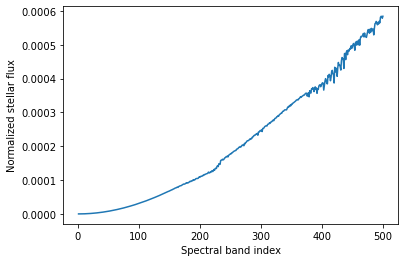

In [6]:
normalized_stellar_flux = read_normalized_stellar_flux(spectral_file)

plt.plot(
    normalized_stellar_flux.coord("spectral_band_index").points,
    normalized_stellar_flux.data,
)
plt.xlabel("Spectral band index")
plt.ylabel("Normalized stellar flux");

5. Calculate the stellar flux per spectral band

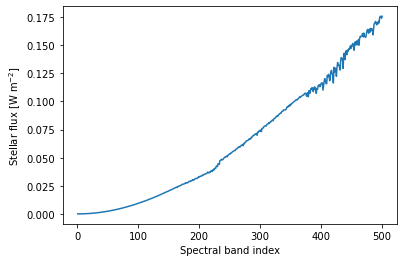

In [7]:
stellar_flux = calc_stellar_flux(spectral_file, stellar_constant_at_1_au)

plt.plot(stellar_flux.coord("spectral_band_index").points, stellar_flux.data)
plt.xlabel("Spectral band index")
plt.ylabel("Stellar flux [W $m^{-2}$]");

6. Check if you use the correct UM output by plotting the m01s01i755 field at a single spectral band

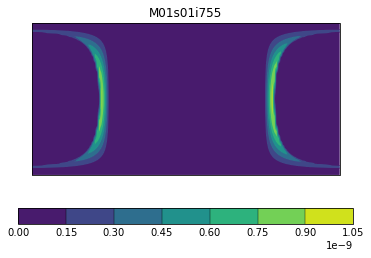

In [8]:
qplt.contourf(planet_transmission_day[100, ...]);

6. Calculate transmission spectrum as a planet-to-star radius ratio

In [9]:
rp_eff_over_rs = calc_transmission_spectrum(
    planet_transmission_day,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)

7. Calculate transmission spectrum averaged over the dayside and the nightside

In [10]:
planet_transmission_night = iris.load_cube(
    str(Path.cwd() / "data" / "test_data" / "netcdf" / "planet_transmission_night.nc")
)

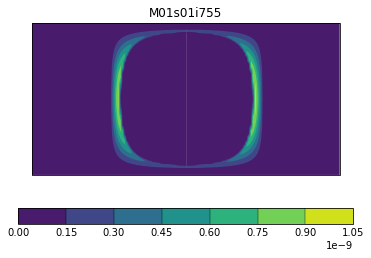

In [11]:
qplt.contourf(planet_transmission_night[100, ...]);

In [12]:
rp_eff_over_rs_dn = calc_transmission_spectrum_day_night_average(
    planet_transmission_day,
    planet_transmission_night,
    spectral_file,
    stellar_constant_at_1_au,
    stellar_radius,
    planet_top_of_atmosphere,
    model=um,
)

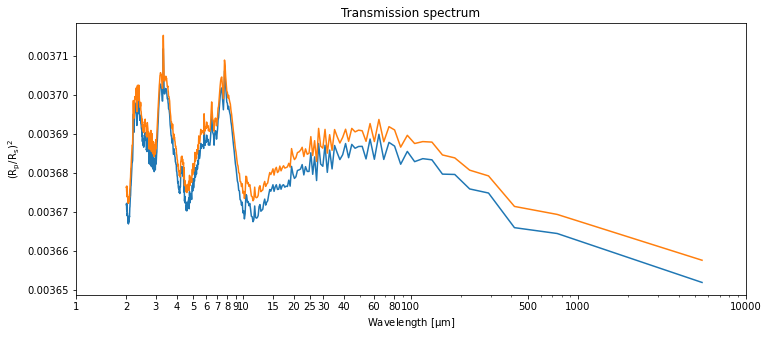

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(
    rp_eff_over_rs.coord("spectral_band_centres").points * 1e6,
    rp_eff_over_rs.data ** 2,
    label="Dayside",
)
ax.plot(
    rp_eff_over_rs.coord("spectral_band_centres").points * 1e6,
    rp_eff_over_rs_dn.data ** 2,
    label="Average over the dayside and nightside",
)

ax.set_title("Transmission spectrum")
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("($R_p/R_s)^2$")
ax.set_xscale("log")

xticks = np.concatenate(
    [
        np.arange(1, 11, 1),
        np.arange(15, 35, 5),
        np.arange(40, 120, 20),
        np.arange(500, 1400, 500),
        np.arange(10000, 10001, 500),
    ]
)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks);